# 1. Imports

In [2]:
# Linear algebra and reading csv
import numpy as np
import pandas as pd

# Ploting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency

# 2. Loading Data

In [3]:
df = pd.read_csv("../data/GMS_ProjectDataset_V2.csv")
df.head()

person_id  GenderCategory  RaceCategory  EthnicityCategory  Age  Region  \
0          1               1             1                  1  100       2   
1          2               1             1                  1   80       1   
2          3               2             1                  1   87       1   
3          4               1             3                  2   82       4   
4          5               1             1                  1   87       2   

   Glipizide_Final  Glimepiride_Final  Glyburide_Final  Metformin_Final  ...  \
0              1.0                0.0              1.0              1.0  ...   
1              0.0                0.0              0.0              0.0  ...   
2              1.0                0.0              1.0              0.0  ...   
3              0.0                0.0              0.0              0.0  ...   
4              0.0                0.0              0.0              0.0  ...   

   Alzheimer_Final  FootUlcer_Final  Abnormal_Glucose_Final  DMScreen_Final  \
0              0.0              0.0                     0.0             0.0   
1              0.0              0.0                     0.0             0.0   
2              0.0              0.0                     0.0             0.0   
3              0.0              0.0                     0.0             0.0   
4              0.0              0.0                     0.0             0.0   

   A1C_Final  GlucoseTest_Final  InsulinTest_Final  DM_Drugs  AnyLab  \
0        0.0                0.0                0.0         1       0   
1        1.0                0.0                0.0         0       1   
2        0.0                0.0                0.0         1       0   
3        0.0                0.0                0.0         1       0   
4        0.0                0.0                0.0         0       0   

   Diabetes_Indicator  
0                 0.0  
1                 1.0  
2                 1.0  
3                 1.0  
4                 1.0  

[5 rows x 44 columns]

# 3. Data Stats and charcteristics

In [4]:
def get_data_char(df):
    data_columns = df.columns
    data_char_df = pd.DataFrame(df.dtypes, columns = ["d_type"])
    data_char_df["#_missing"] = df.isna().sum()
    data_char_df["%_missing"] = df.isna().sum() * 100 / df.shape[0]
    data_char_df["#_unique"] = df.nunique()
    data_char_df["%_unique"] = df.nunique() * 100 / df.shape[0]
    data_char_df["most_frequent"] = df.mode().loc[0]
    
    def get_stats_stats(df):
        return df.aggregate(["min", "max", "mean", "median", "std"]).T
    
    data_char_df = pd.concat([data_char_df,get_stats_stats(df), df.loc[:2,].T], axis = 1)    
    
    return data_char_df
display(get_data_char(df.iloc[:,1:]).style.background_gradient(subset = ["%_unique", "std", "median", "mean", "max", "min", "%_missing"], cmap = "Oranges"))

### Insights:
1. X: We have 43 independent variable, all of which are categorical in nature, except age which is interger. 
2. Y: The target "Diabetes_Indicator" is a binary variable, meaning this is a Binary Classification task
3. The dataset has missing values, and these are in the indicator and test columns.
4. Most unique column is Age with just 7% unique data, of which most frequent value is 85.
5. All 11 indicator features except "A1C" have higher number of False indictor values except as their mean < 0.5
5. There are 4 columns with the most missing datapoints(123). This is interesting as all four columns have the same number of missing datapoints. This suggest that all four values of a row might be missing.
6. The target varible has a mean > 0.5 and median of 1, indicating that the number of positive class (+1) examples are larger than that of number of negative class examples (0)
                                     

## 3.1 Identify kind of missing data pattern:

We identify a pattern of missing datapoints:

1. In the set of 20 missing datapoints
2. In the set of 123 missing datapoints
3. In the set of 70 missing datapoints for target variable

### 3.1.1 Identify pattern in 20 datapoints 
1. Glipizide_Final
2. Glimepiride_Final
3. Glyburide_Final
4. Metformin_Final
5. Pioglitazone_Final
6. Rosiglitazone_Final

In [21]:
df[df["Glipizide_Final"].isna()].isna().sum()[["Glipizide_Final", "Glimepiride_Final", "Glyburide_Final", "Metformin_Final", 
                                               "Pioglitazone_Final", "Rosiglitazone_Final"]]

Glipizide_Final        20
Glimepiride_Final      20
Glyburide_Final        20
Metformin_Final        20
Pioglitazone_Final     20
Rosiglitazone_Final    20
dtype: int64

#### Insight:
1. It appears there is a connection with above 6 indicators, as all columns have identical missing 20 datapoints together.
2. This pattern is appears to be either:
    1. _Missing Not at Random_: As it is possible that these column represent individuals who didn't take any medications 
    2. _Missing at Random_: There might be some systematic reason why the information is missing, maybe these were missed for a subgroup of participants.

### 3.1.2 Identify patterns in 123 missing datapoints for: 
1. A1C_Final
2. GlucoseTest_Final	
3. InsulinTest_Final

In [24]:
df[df["A1C_Final"].isna()].isna().sum()[["A1C_Final", "GlucoseTest_Final", "InsulinTest_Final"]]

A1C_Final            123
GlucoseTest_Final    123
InsulinTest_Final    123
dtype: int64

#### Insight:
Like previously, it appears there is a connection with above 3 indicators, as all columns have identical missing 123 datapoints together, might be **MNAR** or **MAR**.

### 3.1.3 Identify patterns in 70 missing datapoints for target variable

In [26]:
df[df["Diabetes_Indicator"].isna()].isna().sum() 

GenderCategory                    0
RaceCategory                      0
EthnicityCategory                 0
Age                               0
Region                            0
Glipizide_Final                  15
Glimepiride_Final                15
Glyburide_Final                  15
Metformin_Final                  15
Pioglitazone_Final               15
Rosiglitazone_Final              15
Beta_Blockers_Final              15
ACE_Inhibitors_Final             15
ARB_Final                        15
Diuretics_Final                  15
PPI_Final                        15
Levothyroxine_Final              15
CCB_Final                        15
Vasodilators_Final               15
Alpha_Blockers_Final             15
Centrally_Acting_Agents_Final    15
Statins_Final                    15
Anti_Platelets_Final             15
Anti_Coagulants_Final            15
Steroids_Final                   15
Heart_Disease_Final              70
Hypothyroid_Final                70
Anemia_Final                

#### Insight:
Most indicators and tests variables in rows where missing Diabetes_Indicator is missing correlates.

## 3.2 Duplicate rows

In [8]:
df = df.drop("person_id", axis = 1)
df[df.duplicated()]

GenderCategory  RaceCategory  EthnicityCategory  Age  Region  \
140               2             1                  1   87       3   
147               1             1                  1   95       1   
203               2             1                  1   81       4   
295               2             1                  1   86       1   
380               2             1                  1   97       3   
409               1             1                  1   80       1   
411               2             1                  1   82       2   
453               2             1                  1   80       3   
465               2             1                  1   84       3   
515               1             3                  1   84       4   
537               1             1                  1   94       4   
595               2             1                  1   99       1   
617               2             1                  1   86       1   
622               2             1                  1   93       3   
625               2             1                  1   93       3   
635               2             1                  1   86       3   
658               2             1                  1   96       1   
690               2             1                  1   82       2   
692               1             1                  1   95       3   
724               2             1                  1   93       3   
725               2             1                  1   83       3   
739               1             1                  1   81       2   
744               2             1                  1   88       3   
759               1             1                  1   82       2   
778               2             1                  1   83       3   
799               2             1                  1   87       3   
810               1             1                  1   97       1   
844               2             2                  1  100       3   
874               1             1                  1   96       4   
890               2             1                  1   80       3   
899               1             1                  1   86       2   
921               2             1                  1   91       1   
926               2             1                  1   83       2   
929               2             1                  1   84       2   
937               1             1                  1   72       2   

     Glipizide_Final  Glimepiride_Final  Glyburide_Final  Metformin_Final  \
140              0.0                0.0              0.0              0.0   
147              0.0                0.0              0.0              0.0   
203              0.0                0.0              0.0              0.0   
295              0.0                0.0              0.0              0.0   
380              0.0                0.0              0.0              0.0   
409              0.0                0.0              0.0              0.0   
411              0.0                0.0              0.0              0.0   
453              0.0                0.0              0.0              0.0   
465              0.0                0.0              0.0              0.0   
515              0.0                0.0              0.0              0.0   
537              0.0                0.0              0.0              0.0   
595              0.0                0.0              0.0              0.0   
617              0.0                0.0              0.0              0.0   
622              0.0                0.0              0.0              0.0   
625              0.0                0.0              0.0              0.0   
635              0.0                0.0              0.0              0.0   
658              0.0                0.0              0.0              0.0   
690              0.0                0.0              0.0              0.0   
692              0.0                0.0              0.0 

#### Insights:
1. There are 35 duplicated rows

# 4. EDA

In this section, we explore the traits of features and relationships among the features, we explore univarite, bivariate and finally multivariate relationships.

In [10]:
cat_cols = list(df.columns[:-1])
cat_cols.remove("Age")
num_cols = ["Age"]
target_cols = df.columns[-1:]

print("Categorical columns:", cat_cols)
print("Numerical columns:",num_cols)
print("Target column:", target_cols)

Categorical columns: ['GenderCategory', 'RaceCategory', 'EthnicityCategory', 'Region', 'Glipizide_Final', 'Glimepiride_Final', 'Glyburide_Final', 'Metformin_Final', 'Pioglitazone_Final', 'Rosiglitazone_Final', 'Beta_Blockers_Final', 'ACE_Inhibitors_Final', 'ARB_Final', 'Diuretics_Final', 'PPI_Final', 'Levothyroxine_Final', 'CCB_Final', 'Vasodilators_Final', 'Alpha_Blockers_Final', 'Centrally_Acting_Agents_Final', 'Statins_Final', 'Anti_Platelets_Final', 'Anti_Coagulants_Final', 'Steroids_Final', 'Heart_Disease_Final', 'Hypothyroid_Final', 'Anemia_Final', 'Kidney_Disease_Final', 'GERD_Final', 'Neuropathy_Final', 'Eye_Disorder_Final', 'Atherosclerosis_Final', 'Alzheimer_Final', 'FootUlcer_Final', 'Abnormal_Glucose_Final', 'DMScreen_Final', 'A1C_Final', 'GlucoseTest_Final', 'InsulinTest_Final', 'DM_Drugs', 'AnyLab']
Numerical columns: ['Age']
Target column: Index(['Diabetes_Indicator'], dtype='object')


In [11]:
def map_df(data):
    data["GenderCategory"] = data["GenderCategory"].map({1: "Female", 2: "Male"})
    data["RaceCategory"] = data["RaceCategory"].map({1:"White", 2:"Black", 3:"Unknown"})
    data["EthnicityCategory"] = data["EthnicityCategory"].map({1: "Non-Hispanic", 2:"Hispanic", 3: "Unknown"})
    data["Region"] = data["Region"].map({1: "Northeast", 2: "Midwest", 3: "South", 4: "West", 5: "Unknown"})

    return data

df_eda = map_df(df.copy(deep = True))

## 4.1 Univariate

### 4.1.1 Target Variable

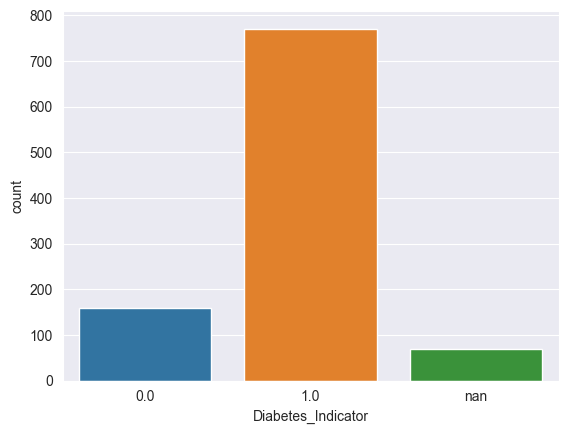

In [12]:
sns.countplot(x = df_eda["Diabetes_Indicator"].fillna("nan"), palette=sns.color_palette("tab10"));

In [13]:
df_eda["Diabetes_Indicator"].value_counts(normalize=True)

Diabetes_Indicator
1.0    0.829032
0.0    0.170968
Name: proportion, dtype: float64

### 4.1.2 Dependent varibles

#### 4.1.2.1 Categorical

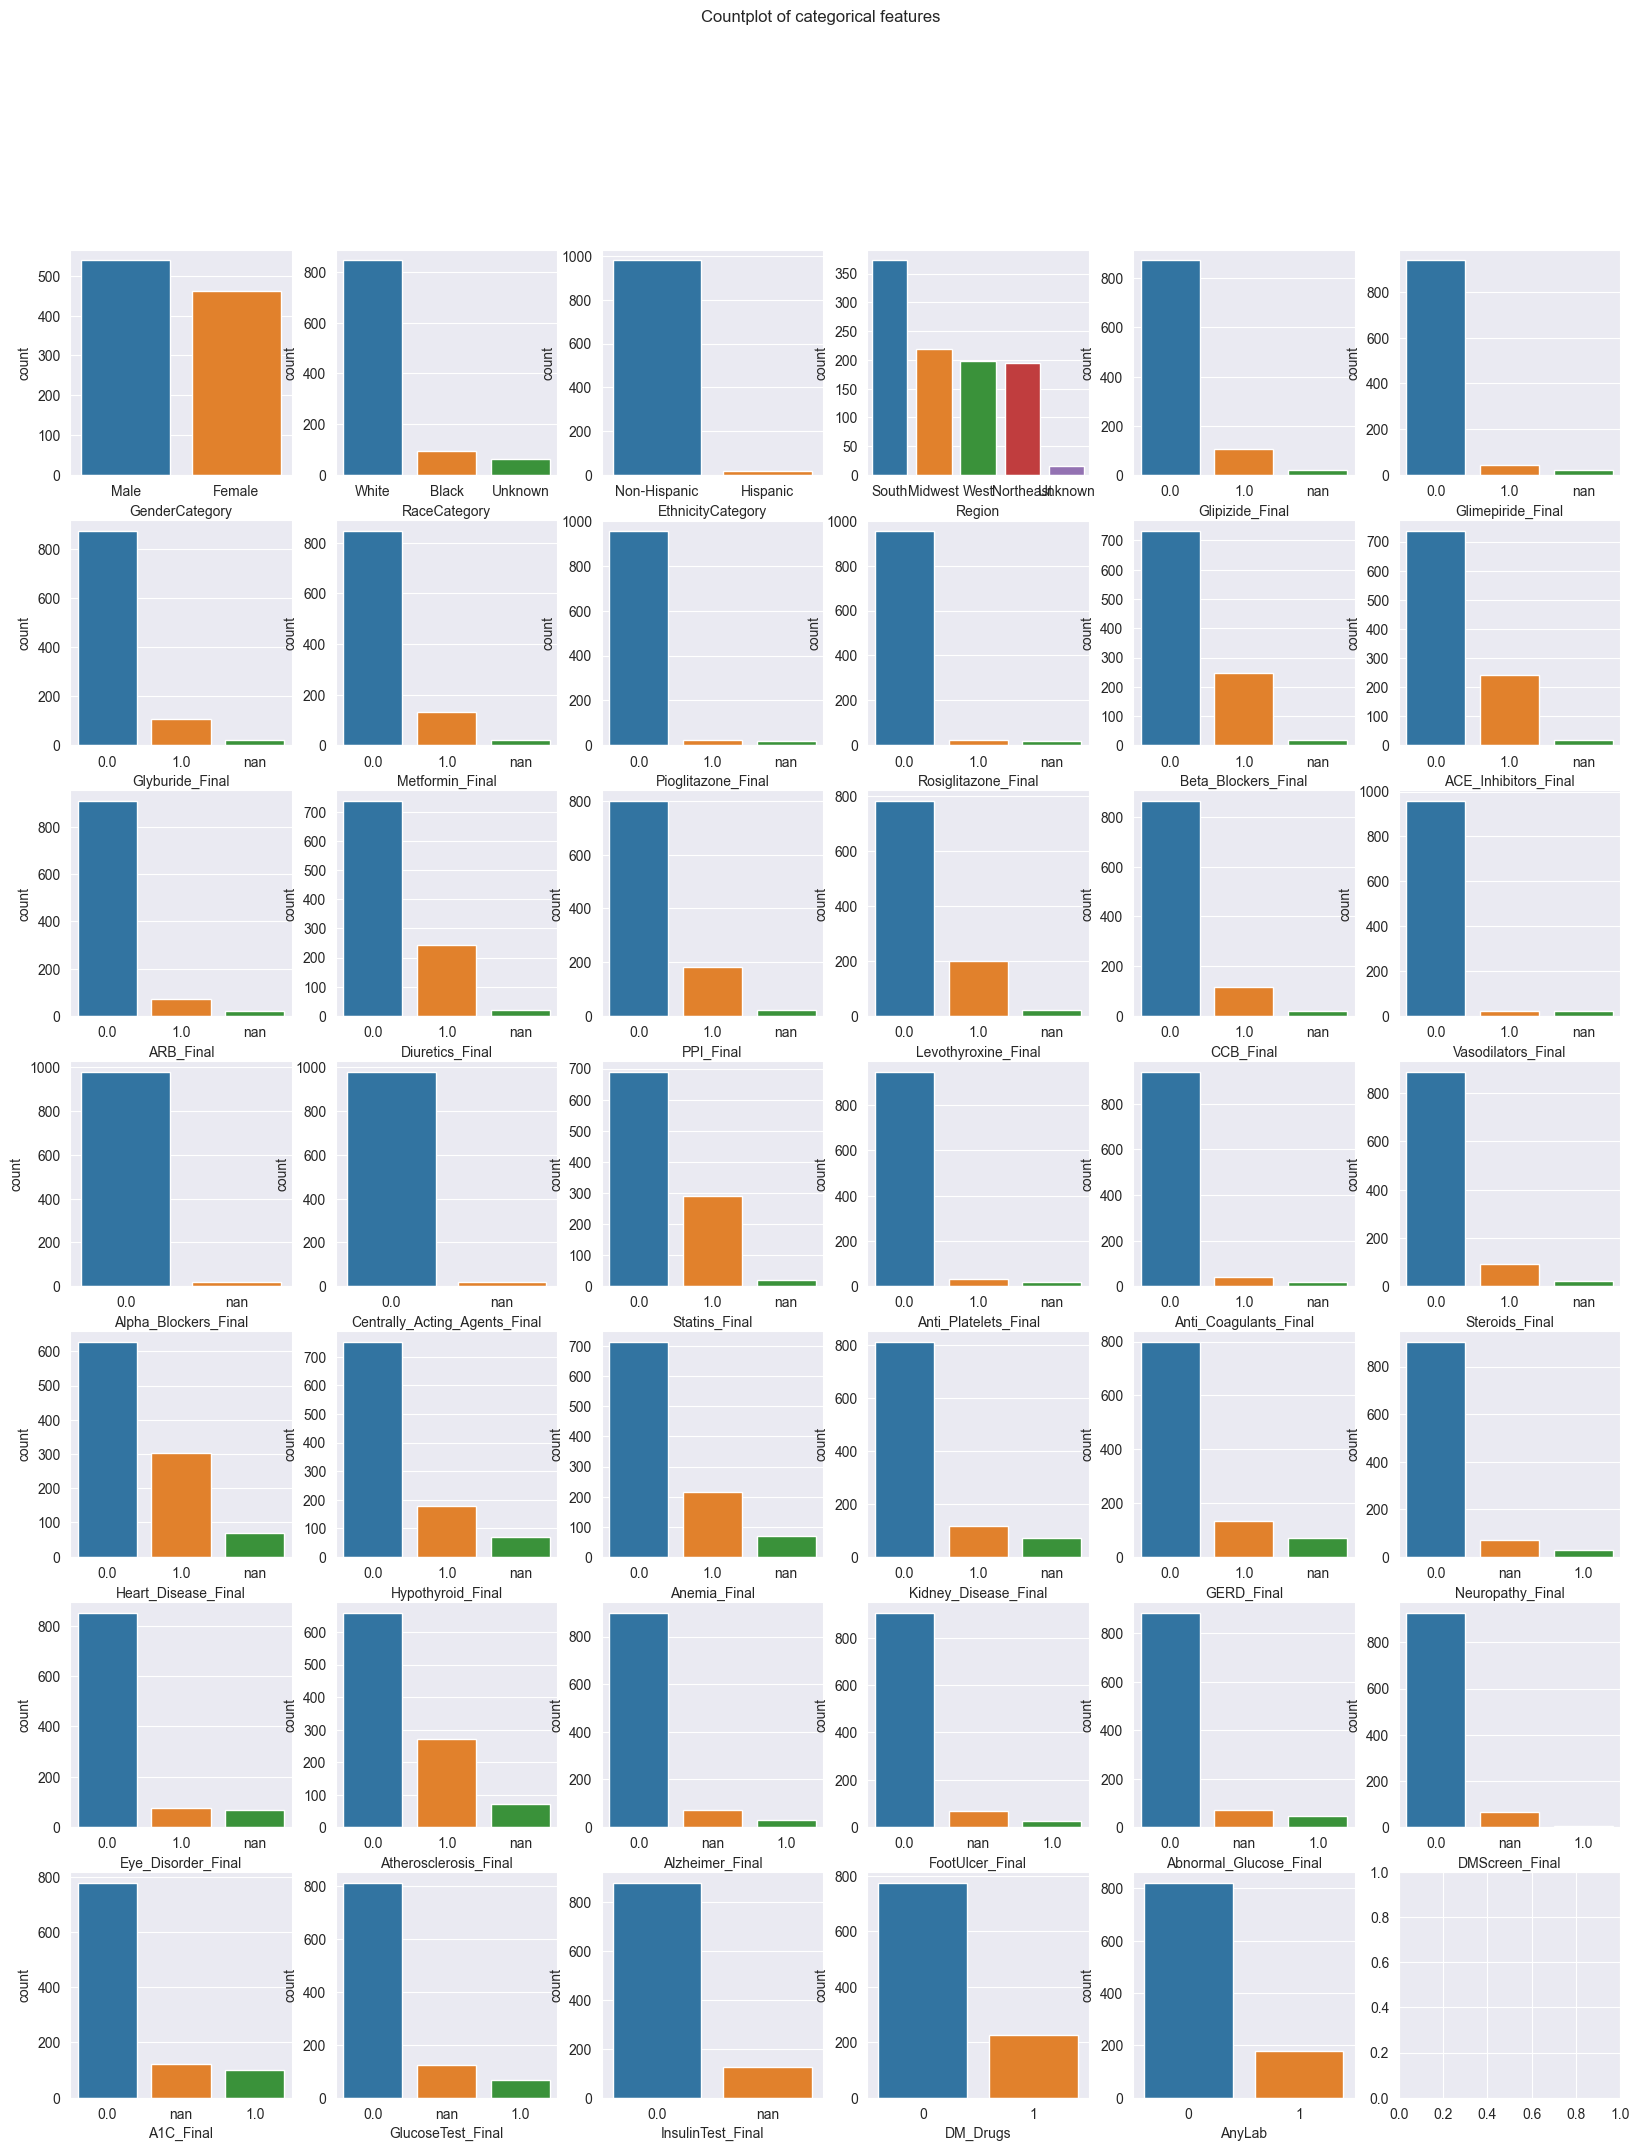

In [14]:
fig, axes = plt.subplots(7, 6, figsize = (20,24))
fig.suptitle('Countplot of categorical features')
for i in range(len(cat_cols)):
    sns.countplot(
        x = df_eda[cat_cols[i]].fillna("nan"),
        palette=sns.color_palette("tab10"), 
        order = df_eda[cat_cols[i]].fillna("nan").value_counts().index,
        ax = axes[i//6, i%6])
plt.show()


#### Insights:

1. The dataset has higher men and is has high imbalances for the race and ethinicity.
2. The dataset is focused from people in different parts of the country with South having the highesh percentage.
3. As for the all indicator and test features, all have higher False indication values.
4. Columns "InsulinTest_Final", "Alpha_Blocker_Final", "Centrally_Acting_Agents_Final" have all the values as False. Based on imputations later, we might decide to remove them.

In [15]:

for i in range(len(cat_cols)):
    print(df_eda[cat_cols[i]].value_counts(normalize=True))

GenderCategory
Male      0.539
Female    0.461
Name: proportion, dtype: float64
RaceCategory
White      0.846
Black      0.093
Unknown    0.061
Name: proportion, dtype: float64
EthnicityCategory
Non-Hispanic    0.98
Hispanic        0.02
Name: proportion, dtype: float64
Region
South        0.373
Midwest      0.219
West         0.198
Northeast    0.195
Unknown      0.015
Name: proportion, dtype: float64
Glipizide_Final
0.0    0.890816
1.0    0.109184
Name: proportion, dtype: float64
Glimepiride_Final
0.0    0.957143
1.0    0.042857
Name: proportion, dtype: float64
Glyburide_Final
0.0    0.891837
1.0    0.108163
Name: proportion, dtype: float64
Metformin_Final
0.0    0.864286
1.0    0.135714
Name: proportion, dtype: float64
Pioglitazone_Final
0.0    0.97551
1.0    0.02449
Name: proportion, dtype: float64
Rosiglitazone_Final
0.0    0.97449
1.0    0.02551
Name: proportion, dtype: float64
Beta_Blockers_Final
0.0    0.747959
1.0    0.252041
Name: proportion, dtype: float64
ACE_Inhibitors_Fina

#### 4.1.2.1 Numerical

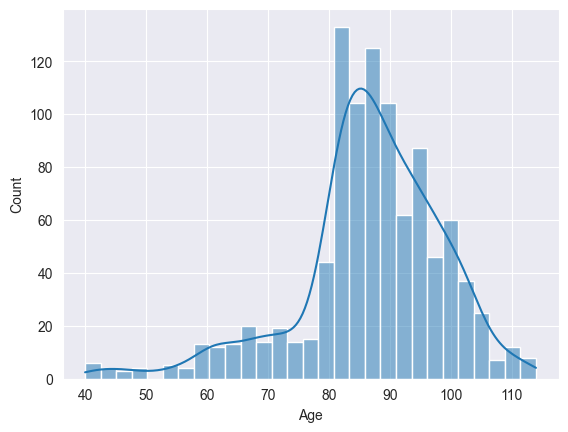

In [23]:
sns.histplot(data = df_eda, x = "Age", kde = True, palette=sns.color_palette("tab10"));

#### Insights:

1. The "Age" follows a somewhat Normal distribution with a slight skewness to the left.
2. The median and mean are 87 and 86.76 respectively.

## 4.2 Bivariavte

### 4.2.1 Relation of dependent features with target

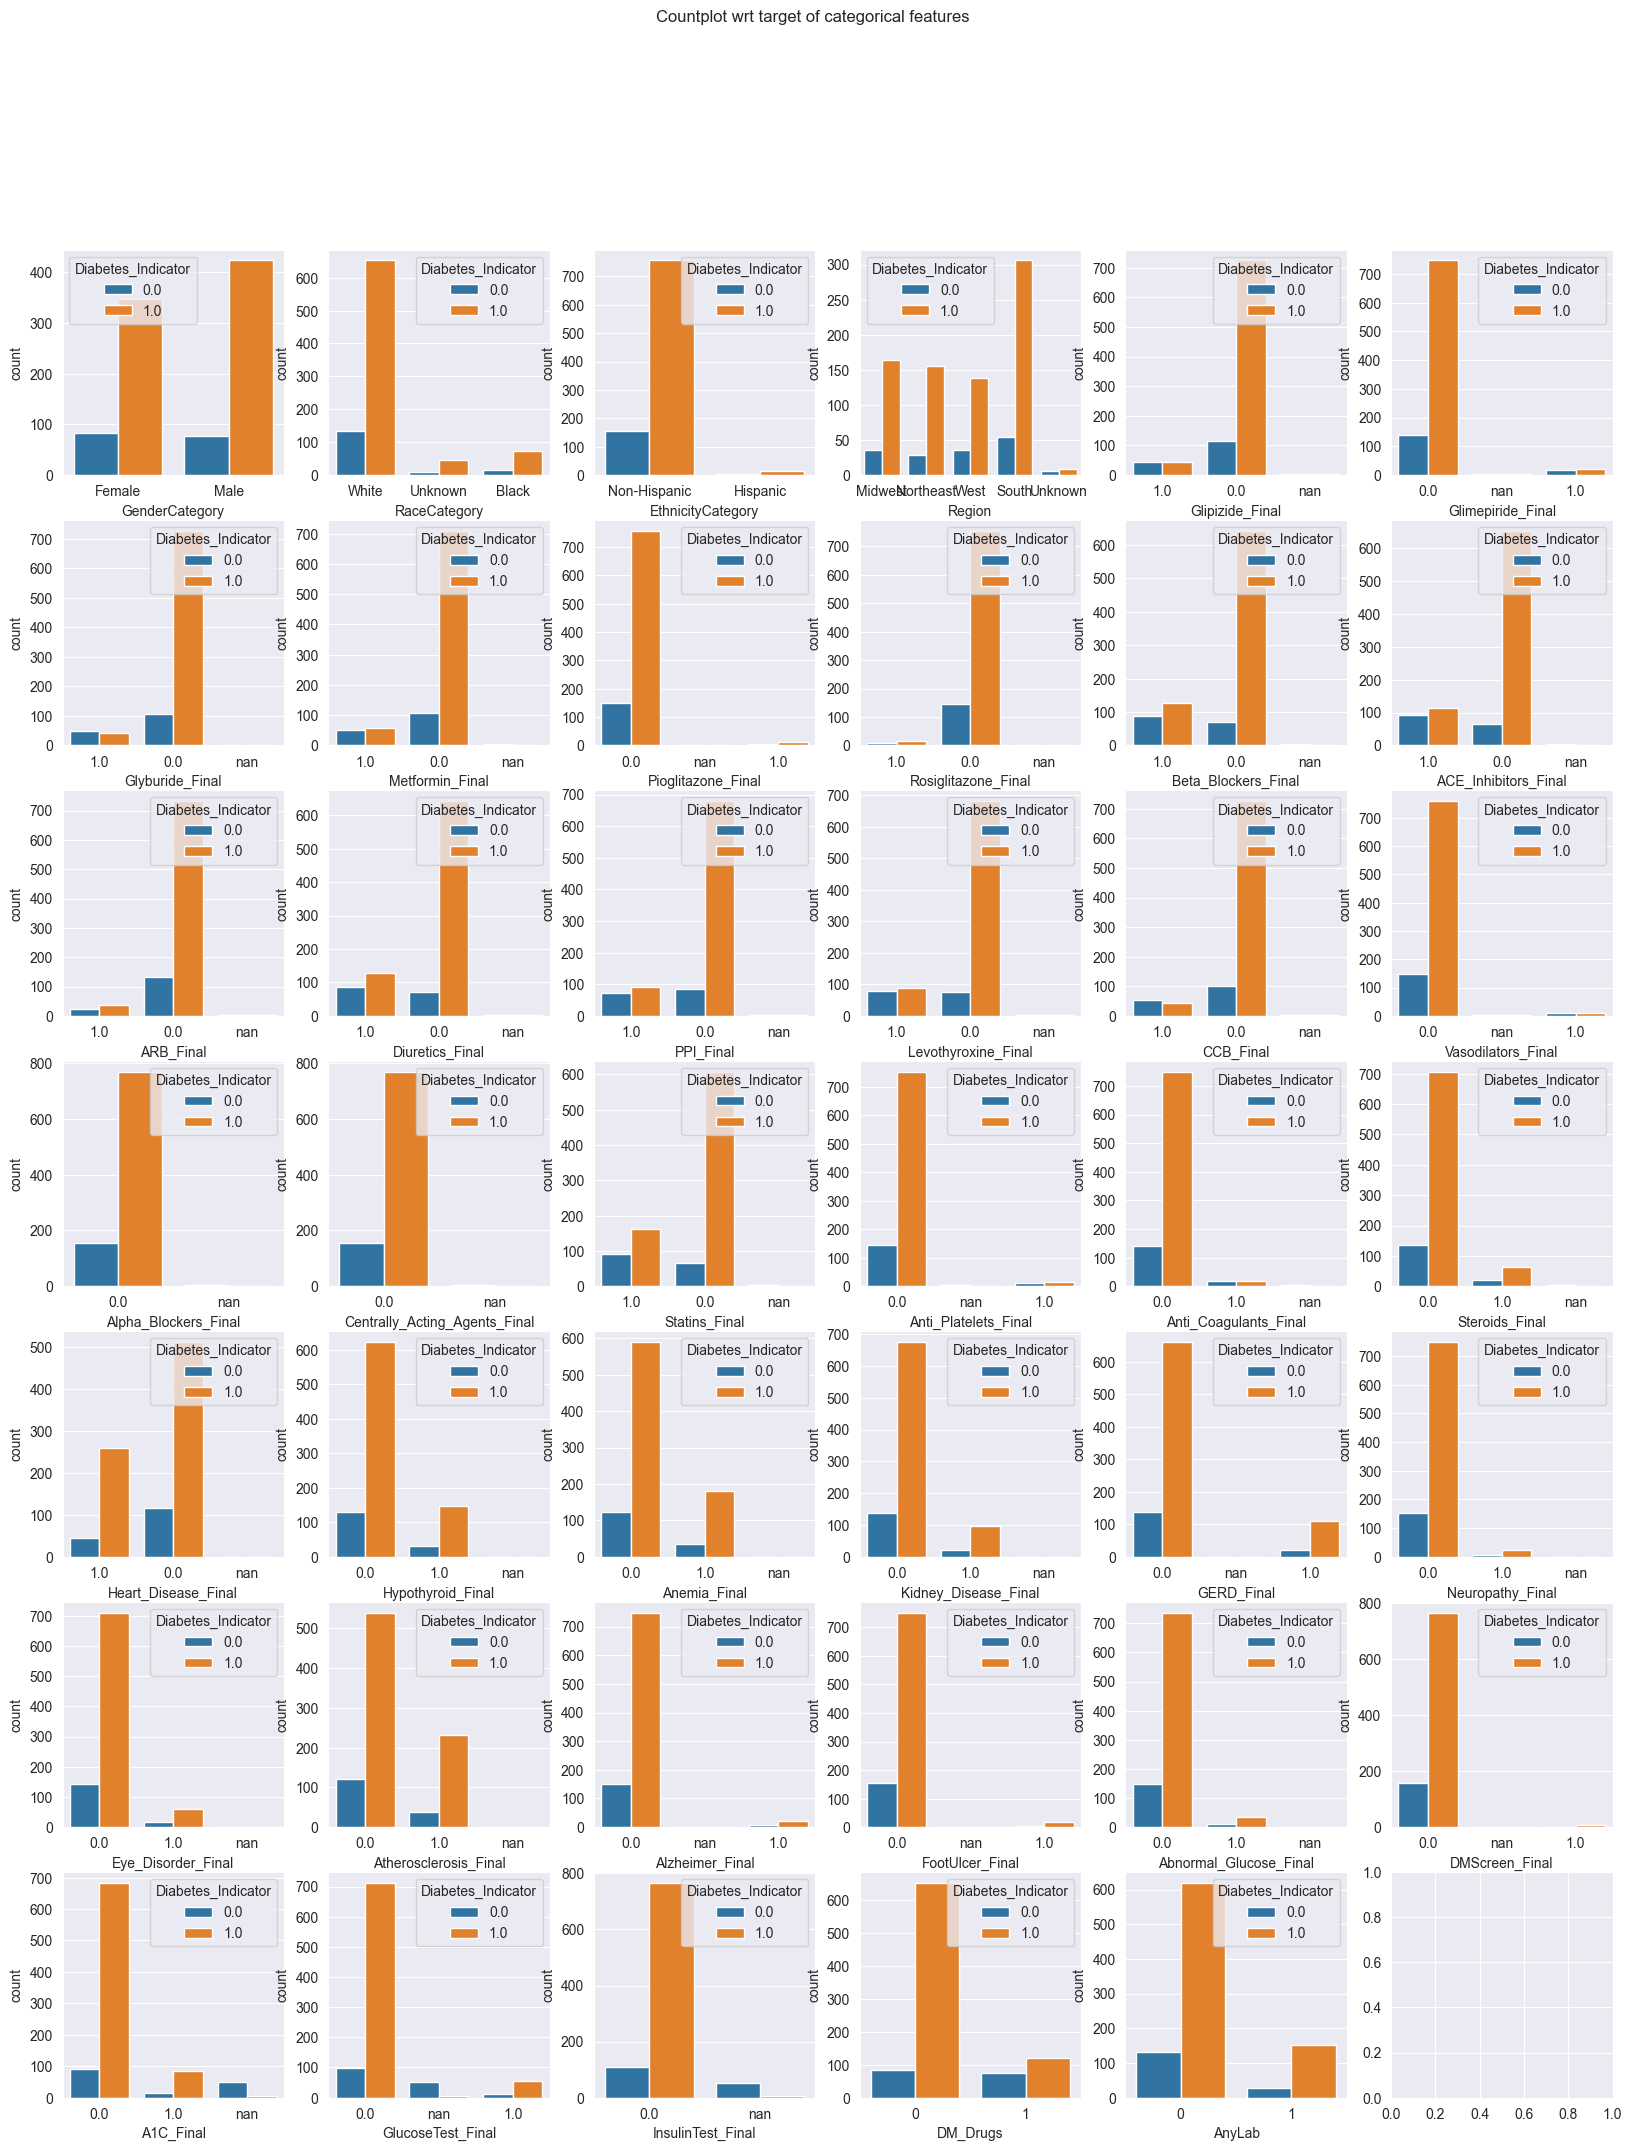

In [24]:
fig, axes = plt.subplots(7, 6, figsize = (20,24))
fig.suptitle('Countplot wrt target of categorical features')
for i in range(len(cat_cols)):
    sns.countplot(
        x = df_eda[cat_cols[i]].fillna("nan"), 
        palette=sns.color_palette("tab10"), 
        hue = df_eda["Diabetes_Indicator"],
        ax = axes[i//6, i%6])
plt.show()

Insight:
1. The positives class seems to be more prominent with Males than Female
2. Of all the indicators "Heart_Disease_Final" has the highest proportions of positive distribution, might be useful for positive case

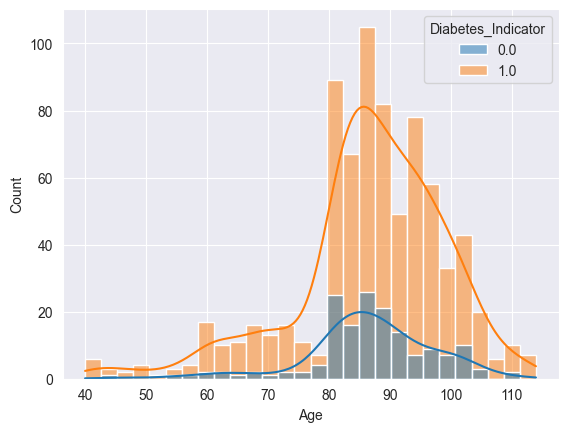

In [25]:
sns.histplot(data = df_eda, x = "Age", kde = True, hue = "Diabetes_Indicator", palette=sns.color_palette("tab10"));

#### Insight:
Age is a clear cut variable for the influencing the outcome.

In [27]:
# Remove constant rows
df_eda = df_eda.drop(["InsulinTest_Final", 'Alpha_Blockers_Final', 'Centrally_Acting_Agents_Final'], axis =1 )

## 4.3 Multivariate Heatmap - Cramer's V
Since most of the variable are categorical, Cramer's V correlation makes more sense.

In [29]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0] 
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1 
    return np.sqrt(stat/(obs*mini))

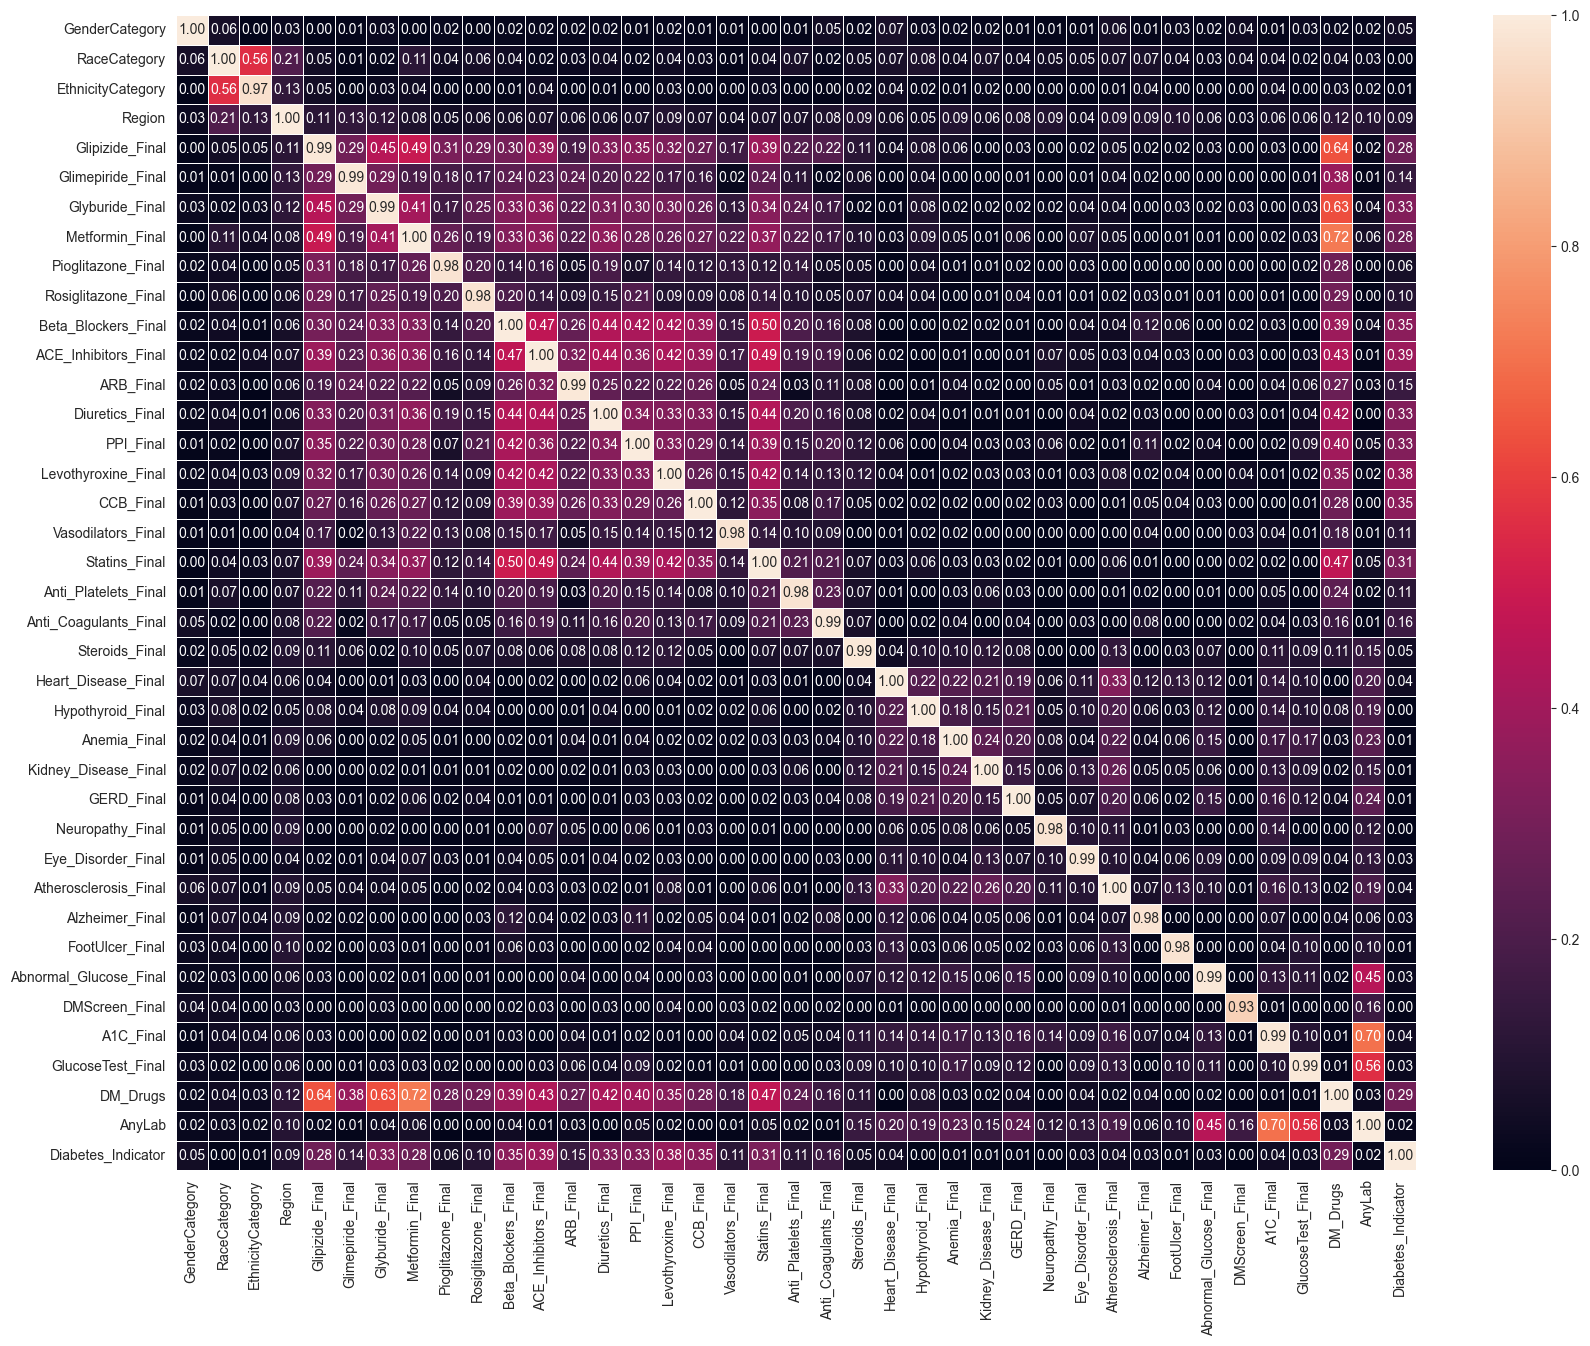

In [31]:
df_corr = df_eda.drop("Age", axis = 1)
rows= []
for var1 in df_corr:
    col = []
    for var2 in df_corr :
        cramers =cramers_V(df_corr[var1], df_corr[var2])
        col.append(round(cramers,2))
    rows.append(col)
  
cramers_results = np.array(rows)
df_corr_cramers = pd.DataFrame(cramers_results, columns = df_corr.columns, index =df_corr.columns)

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df_corr_cramers, annot = True, fmt = ".2f", ax=ax, linewidths=.5);

#### Insight:
1. High correlation with DMDrug_Indicator:
    Glipizide_Indicator, Glyburide_Indicator , Metformin_Indicator 

2. High correlation with AnyLab_Indicator:
A1C_Indicator , GlucoseTest_Indicator

3. Diabetes_Indicator is weak correlation with AnyLab_Indicator and A1C_Indicator

## 4.4. Y_Data Profiling (Mentioned in Rubric :))

In [32]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report')

In [33]:
profile.to_file("output_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
profile